In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from matplotlib import cm  # color map
from mpl_toolkits.mplot3d import Axes3D
from operator import itemgetter
from numpy import exp
from numpy import sqrt
from numpy import cos
from numpy import e
from numpy import pi
from matplotlib.animation import FuncAnimation

In [3]:
# michalewicz_graph.py

X = np.linspace(0, 3.2, 50)    
Y = np.linspace(0, 3.2, 50)    
X, Y = np.meshgrid(X, Y)

# Michalewicz function
Z = -1 * ( (np.sin(X) * np.sin((1 * X**2) / np.pi)**20) + \
           (np.sin(Y) * np.sin((2 * Y**2) / np.pi)**20) )

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, \
  rstride=1, cstride=1, cmap=cm.jet, \
  edgecolor='darkred', linewidth=0.1)

ax.set_xlabel('x', fontsize=10)
ax.set_ylabel('y', fontsize=10)
ax.set_zlabel('f(x,y)', fontsize=10)
ax.tick_params(axis='both', which='major',
  labelsize=6)
    
plt.show()

TypeError: FigureBase.gca() got an unexpected keyword argument 'projection'

<Figure size 640x480 with 0 Axes>

Gradient-based optimisation with the use of finite differences

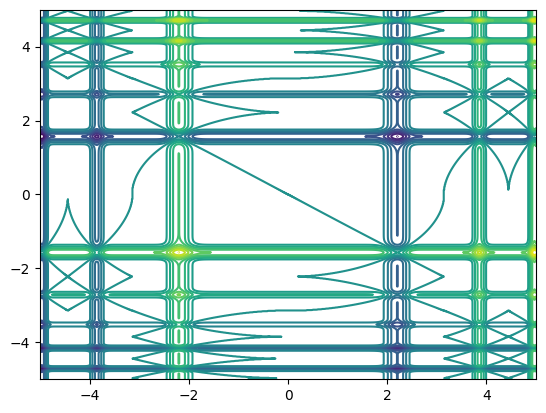

In [4]:
def f(x, y): # Defining Michalewicz function
    return -1 * ( (np.sin(x) * np.sin((1 * x**2) / np.pi)**20) + \
           (np.sin(y) * np.sin((2 * y**2) / np.pi)**20) )
           
v_func = np.vectorize(f) # Getting array as output instead of scalar

x, y = np.meshgrid(np.linspace(-5, 5, 1000),
                   np.linspace(-5, 5, 1000))

fig, ax = plt.subplots(1)
ax.contour(x, y, v_func(x, y), levels=20)
plt.show()

In [5]:
h = 10**(-6) # Finite-difference approximation

gradient = lambda x, y: np.array([ f(x+h, y)-f(x, y) , f(x, y+h)-f(x, y) ]) # Calculating gradient, finite-difference approximation instead of derivatives
gradnorm = lambda x, y: np.sum(gradient(x, y)**2)**(1/2) # normalized gradient
calcdir = lambda x, y: -gradient(x, y) / gradnorm(x, y) # normalized search direction

In [6]:
alpha = 0.2
ro = 0.5 # values between 0 and 1 
mu = 10**(-4) # standaard value

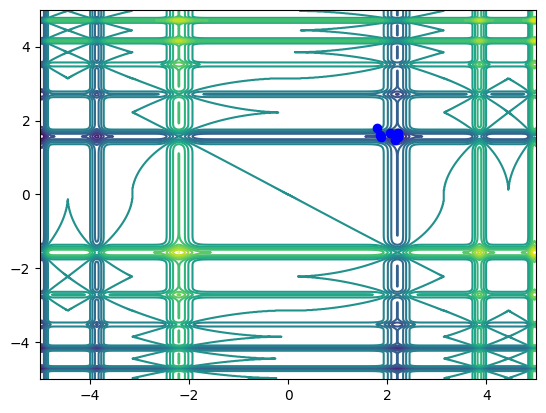

In [7]:
x0 = 1.8 # starting point
y0 = 1.8

fig, ax = plt.subplots(1)
ax.contour(x, y, v_func(x, y), levels=20)
plt.plot(x0, y0,'bo')

for i in range(0,20):
    sdir = calcdir(x0, y0) # calculate the gradient to get the direction

    # Backtracking algorithm
    step = alpha
    while True:
        if v_func(x0 + step*sdir[0], y0 + step*sdir[1]) <= v_func(x0, y0) + mu*step*np.dot(gradient(x0, y0),sdir):
                break
        step = ro*step

    plt.plot(x0 + step*sdir[0], y0 + step*sdir[1],'bo') # calculate the placement of the next point
    x0 = x0 + step*sdir[0] # update point cooridnates
    y0 = y0 + step*sdir[1] # update point cooridnates

plt.show()

Nelder Mead Function

In [ ]:
def func(v): 
   return -1 * ( (np.sin(v[0]) * np.sin((1 * v[0]**2) / np.pi)**20) + \
            (np.sin(v[1]) * np.sin((2 * v[1]**2) / np.pi)**20))
    

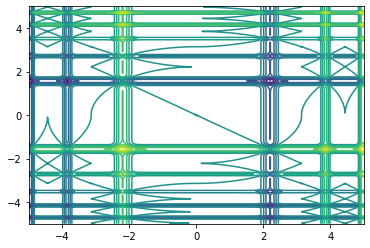

In [ ]:
X, Y = np.meshgrid(np.linspace(-5, 5, 2000),
                   np.linspace(-5, 5, 2000))

Z = func([X,Y])

plt.contour(X, Y, Z, levels = 20)
plt.show()

In [ ]:
def i_trg(x, y, c):
    x1 = x + c
    y1 = y
    x2 = x + c/2
    y2 = y + (c/2)*(3**(1/2))
    return list(zip(np.array([x,x1,x2]), np.array([y,y1,y2])))

In [ ]:
def BGW(V, f):
    T = [(V[i], f(V[i])) for i in range(len(V)) ]
    return sorted(T, key=itemgetter(1))

    # alternatively, equivalent:
    #return sorted(T, key=lambda column: column[1]) 

In [ ]:
def midpoint(o_trg, A=0, B=1):
    return ((o_trg[A][0][0] + o_trg[B][0][0])/2,
            (o_trg[A][0][1] + o_trg[B][0][1])/2)

def reflection(o_trg):
    M = midpoint(o_trg)
    W = o_trg[2][0]
    return (2*M[0] - W[0], 2*M[1] - W[1])

def expansion(o_trg):
    M = midpoint(o_trg)
    R = reflection(o_trg)
    return (2*R[0] - M[0], 2*R[1] - M[1])

def contraction(o_trg, f):
    M = midpoint(o_trg)
    R = reflection(o_trg)
    W = o_trg[2][0]
    insC = ((W[0] + M[0])/2, (W[1] + M[1])/2)
    outC = ((R[0] + M[0])/2, (R[1] + M[1])/2)
    return (insC, outC)

def shrink(o_trg, f):
    M, S  = midpoint(o_trg), midpoint(o_trg, A=0, B=2)
    return M, S

In [ ]:
def nelder_mead(o_trg, f, iterations, plot=False):
    print("k \t {:^20}   \t {:^20}   \t {:^20}".format("Best point", "Good point", "Worst point"))
     
    for i in range(iterations):
        
        if (i == 0):     
            print("{} \t f({:.2f},{:.2f}) = {:.2f}   \t f({:.2f},{:.2f}) = {:.2f}   \t f({:.2f},{:.2f}) = {:.2f}"
                    .format(i+1, o_trg[0][0][0], o_trg[0][0][1], f(o_trg[0][0]),
                            o_trg[1][0][0], o_trg[1][0][1], f(o_trg[1][0]),
                            o_trg[2][0][0], o_trg[2][0][1], f(o_trg[2][0])))

            if plot:
                bgw = np.array([o_trg[i][0] for i in range(len(o_trg))])
                plt.clf()
                plt.contour(X, Y, Z, levels = 50)
                plt.plot((bgw[0,0], bgw[1,0]), (bgw[0,1], bgw[1,1]), '-b')
                plt.plot((bgw[2,0], bgw[1,0]), (bgw[2,1], bgw[1,1]), '-b')
                plt.plot((bgw[0,0], bgw[2,0]), (bgw[0,1], bgw[2,1]), '-b')
                plt.plot(bgw[0,0], bgw[0,1], '.r')
                plt.show(block=False)
                plt.pause(0.1)
        
        
        R = reflection(o_trg)
        G = o_trg[1][0]
        B = o_trg[0][0]
        
        if f(R) < f(G):
            # Case 1: reflection found a better point than Good point

            if f(B) < f(R):
                # Case 1a: reflected point is not better than Best point -> replace Worst with R and end this iteration
                
                o_trg = BGW([B, G, R], f)              
            else:
                # Case 1b: reflected point is better than Best point -> go even further (expansion)
                
                E = expansion(o_trg)
                if f(E) < f(R):
                    # Case 1ba: expanded point is better than reflected point -> replace Worst with E and end this iteration
                    o_trg = BGW([B, G, E], f)
                else:
                    # Case 1bb: expanded point is not better than reflected point -> replace Worst with R and end this iteration
                    o_trg = BGW([B, G, R], f)
        else:
            # Case 2: reflection found a worse point than Good point

            W = o_trg[2][0]
            if f(R) > f(W):
                # Case 2a: reflected point is worse than Worst point -> perform inside contraction
                C = contraction(o_trg, f)[0]
            else:
                # Case 2b: reflected point is not worse than Worst point -> perform outside contraction
                C = contraction(o_trg, f)[1]

            if f(C) < f(W):
                # Case 3a: contraction worked -> replace Worst with C and end this iteration
                o_trg = BGW([B, G, C], f)
            else:
                # Case 3b: contraction did not work -> shrink the triangle
                M, S = shrink(o_trg, f)
                o_trg = BGW([B, M, S], f)
         
        print("{} \t f({:.2f},{:.2f}) = {:.2f}   \t f({:.2f},{:.2f}) = {:.2f}   \t f({:.2f},{:.2f}) = {:.2f}"
              .format(i+1, o_trg[0][0][0], o_trg[0][0][1], f(o_trg[0][0]),
                      o_trg[1][0][0], o_trg[1][0][1], f(o_trg[1][0]),
                      o_trg[2][0][0], o_trg[2][0][1], f(o_trg[2][0])))
        
        if plot:
            bgw = np.array([o_trg[i][0] for i in range(len(o_trg))])
            plt.clf()
            plt.contour(X, Y, Z, levels = 50)
            plt.plot((bgw[0,0], bgw[1,0]), (bgw[0,1], bgw[1,1]), '-b')
            plt.plot((bgw[2,0], bgw[1,0]), (bgw[2,1], bgw[1,1]), '-b')
            plt.plot((bgw[0,0], bgw[2,0]), (bgw[0,1], bgw[2,1]), '-b')
            plt.plot(bgw[0,0], bgw[0,1], '.r')
            plt.show(block=False)
            plt.pause(0.1)
            
    plt.show()
                
    return o_trg

In [ ]:
X, Y = np.meshgrid(np.linspace(-2, 3, 2000),
                   np.linspace(-2, 3, 2000))
v_func = np.vectorize(func)
Z = func([X,Y])

In [ ]:
trg = i_trg(1,1,1)
trg

[(1.0, 1.0), (2.0, 1.0), (1.5, 1.8660254037844386)]

In [ ]:
o_trg = BGW(trg,func)
o_trg

[((2.0, 1.0), -0.37016851908256937),
 ((1.5, 1.8660254037844386), -0.010852951083362247),
 ((1.0, 1.0), -2.5573872831813936e-05)]

k 	      Best point        	      Good point        	     Worst point     
1 	 f(2.00,1.00) = -0.37   	 f(1.50,1.87) = -0.01   	 f(1.00,1.00) = -0.00


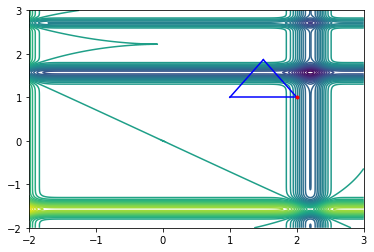

1 	 f(2.00,1.00) = -0.37   	 f(2.50,1.87) = -0.11   	 f(1.50,1.87) = -0.01


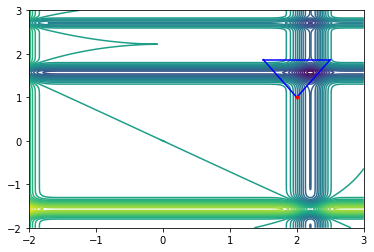

2 	 f(1.88,1.65) = -0.88   	 f(2.00,1.00) = -0.37   	 f(2.50,1.87) = -0.11


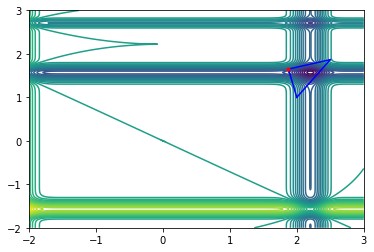

3 	 f(2.22,1.60) = -1.77   	 f(1.88,1.65) = -0.88   	 f(2.00,1.00) = -0.37


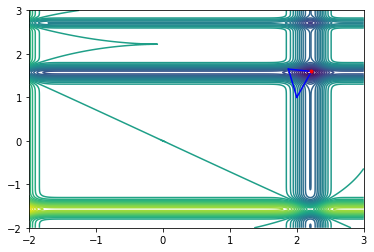

4 	 f(2.22,1.60) = -1.77   	 f(1.88,1.65) = -0.88   	 f(2.07,1.93) = -0.57


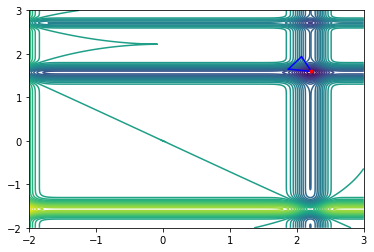

5 	 f(2.22,1.60) = -1.77   	 f(1.88,1.65) = -0.88   	 f(2.06,1.78) = -0.67


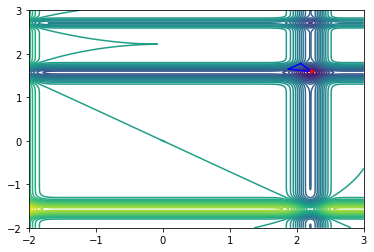

[((2.21875, 1.5953924651018014), -1.7726206288015953),
 ((1.875, 1.649519052838329), -0.8826256374552195),
 ((2.05859375, 1.7780696987125815), -0.6676111457812307)]

In [ ]:
nelder_mead(o_trg,func,5,plot=True)

Particle Swarm Optimization

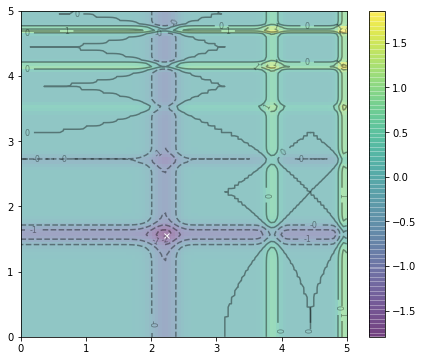

In [ ]:
 
def f(x,y):
    "Michalewicz function"
    return -1 * ( (np.sin(x) * np.sin((1 * x**2) / np.pi)**20) + \
           (np.sin(y) * np.sin((2 * y**2) / np.pi)**20) )
    
# Contour plot: With the global minimum showed as "X" on the plot
x, y = np.array(np.meshgrid(np.linspace(0,5,100), np.linspace(0,5,100)))
z = f(x, y)
# Find the global minimum
x_min = x.ravel()[z.argmin()]
y_min = y.ravel()[z.argmin()]
# plot
plt.figure(figsize=(8,6))
plt.imshow(z, extent=[0, 5, 0, 5], origin='lower', cmap='viridis', alpha=0.5)
plt.colorbar()
plt.plot([x_min], [y_min], marker='x', markersize=5, color="white")
contours = plt.contour(x, y, z, 10, colors='black', alpha=0.4)
plt.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
plt.show()

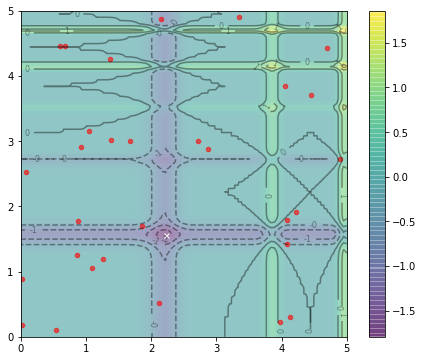

In [ ]:
# Create particles
n_particles = 30
np.random.seed(100)
X = np.random.rand(2, n_particles) * 5
V = np.random.randn(2, n_particles) * 0.1

# plot the particles   
plt.figure(figsize=(8,6))
plt.imshow(z, extent=[0, 5, 0, 5], origin='lower', cmap='viridis', alpha=0.5)
plt.colorbar()
plt.plot([x_min], [y_min], marker='x', markersize=5, color="white")
contours = plt.contour(x, y, z, 10, colors='black', alpha=0.4)
plt.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
plt.scatter(X[0], X[1], color='red', s=20, alpha=0.6)
plt.show()

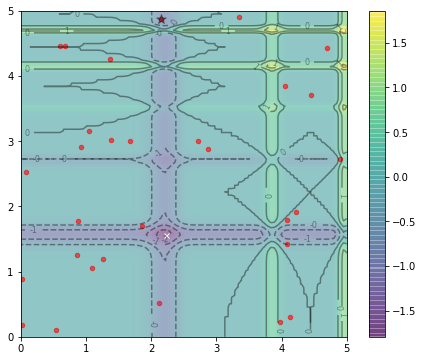

In [ ]:
# Initialize data
pbest = X
pbest_obj = f(X[0], X[1])
gbest = pbest[:, pbest_obj.argmin()]
gbest_obj = pbest_obj.min()

# plot the particles and the best position
plt.figure(figsize=(8,6))
plt.imshow(z, extent=[0, 5, 0, 5], origin='lower', cmap='viridis', alpha=0.5)
plt.colorbar()
plt.plot([x_min], [y_min], marker='x', markersize=5, color="white")
contours = plt.contour(x, y, z, 10, colors='black', alpha=0.4)
plt.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
plt.scatter(X[0], X[1], color='red', s=20, alpha=0.6)
plt.scatter([gbest[0]], [gbest[1]], marker='*', s=100, color='black', alpha=0.4)
plt.show()

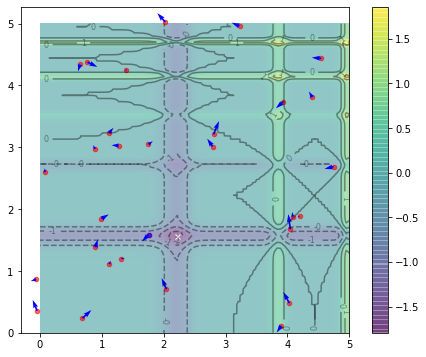

In [ ]:
c1 = c2 = 0.1
w = 0.8
# One iteration
r = np.random.rand(2)
V = w * V + c1*r[0]*(pbest - X) + c2*r[1]*(gbest.reshape(-1,1)-X)
X = X + V
obj = f(X[0], X[1])
pbest[:, (pbest_obj >= obj)] = X[:, (pbest_obj >= obj)]
pbest_obj = np.array([pbest_obj, obj]).max(axis=0)
gbest = pbest[:, pbest_obj.argmin()]
gbest_obj = pbest_obj.min()

plt.figure(figsize=(8,6))
plt.imshow(z, extent=[0, 5, 0, 5], origin='lower', cmap='viridis', alpha=0.5)
plt.colorbar()
plt.plot([x_min], [y_min], marker='x', markersize=5, color="white")
contours = plt.contour(x, y, z, 10, colors='black', alpha=0.4)
plt.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
plt.scatter(X[0], X[1], color='red', s=20, alpha=0.6)
plt.quiver(X[0], X[1], V[0], V[1], color='blue', width=0.005, angles='xy', scale_units='xy', scale=1)
plt.scatter(gbest[0], gbest[1], color='blue', s=20, alpha=0.6)
plt.show()

(0.0, 5.0)

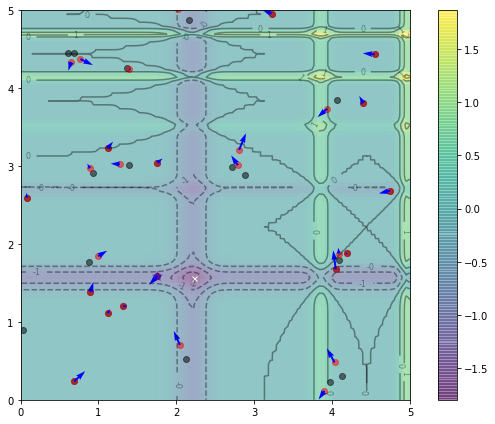

In [ ]:
# Set up base figure: The contour map
fig, ax = plt.subplots(figsize=(8,6))
fig.set_tight_layout(True)
img = ax.imshow(z, extent=[0, 5, 0, 5], origin='lower', cmap='viridis', alpha=0.5)
fig.colorbar(img, ax=ax)
ax.plot([x_min], [y_min], marker='x', markersize=5, color="white")
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
pbest_plot = ax.scatter(pbest[0], pbest[1], marker='o', color='black', alpha=0.5)
p_plot = ax.scatter(X[0], X[1], marker='o', color='red', alpha=0.5)
p_arrow = ax.quiver(X[0], X[1], V[0], V[1], color='blue', width=0.005, angles='xy', scale_units='xy', scale=1)
gbest_plot = plt.scatter([gbest[0]], [gbest[1]], marker='*', s=100, color='blue', alpha=0.4)
ax.set_xlim([0,5])
ax.set_ylim([0,5])

In [ ]:
def update():
    "Function to do one iteration of particle swarm optimization"
    global V, X, pbest, pbest_obj, gbest, gbest_obj
    # Update params
    r1, r2 = np.random.rand(2)
    V = w * V + c1*r1*(pbest - X) + c2*r2*(gbest.reshape(-1,1)-X)
    X = X + V
    obj = f(X[0], X[1])
    pbest[:, (pbest_obj >= obj)] = X[:, (pbest_obj >= obj)]
    pbest_obj = np.array([pbest_obj, obj]).min(axis=0)
    gbest = pbest[:, pbest_obj.argmin()]
    gbest_obj = pbest_obj.min()

In [ ]:
def animate(i):
    "Steps of PSO: algorithm update and show in plot"
    title = 'Iteration {:02d}'.format(i)
    # Update params
    update()
    # Set picture
    ax.set_title(title)
    pbest_plot.set_offsets(pbest.T)
    p_plot.set_offsets(X.T)
    p_arrow.set_offsets(X.T)
    p_arrow.set_UVC(V[0], V[1])
    gbest_plot.set_offsets(gbest.reshape(1,-1))
    return ax, pbest_plot, p_plot, p_arrow, gbest_plot

In [ ]:
anim = FuncAnimation(fig, animate, frames=list(range(1,50)), interval=500, blit=False, repeat=True)
anim.save("PSO.gif", dpi=120, writer="imagemagick")
 
print("PSO found best solution at f({})={}".format(gbest, gbest_obj))
print("Global optimal at f({})={}".format([x_min,y_min], f(x_min,y_min)))

MovieWriter imagemagick unavailable; using Pillow instead.


PSO found best solution at f([2.20263297 1.57063887])=-1.8013011988953007
Global optimal at f([2.2222222222222223, 1.5656565656565655])=-1.794144469027823


Bayesian optimization

In [8]:
def f(x):
    "Michalewicz function"
    return -1 * ( (np.sin(x[0]) * np.sin((1 * x[0]**2) / np.pi)**20) + \
           (np.sin(x[1]) * np.sin((2 * x[1]**2) / np.pi)**20) )

In [9]:
X = np.linspace(-5, 5, 2001)
Y = np.linspace(-5, 5, 2001)

Xm, Ym = np.meshgrid(X,Y)

Z = f([Xm,Ym])

# starting points

xstart = np.linspace(-4, 4, 10)
ystart = np.linspace(-4, 4, 10)

xstartm, ystartm = np.meshgrid(xstart,ystart)

xystart = np.array([xstartm.reshape(xstartm.size,1).flatten(), ystartm.reshape(ystartm.size,1).flatten()])

zstart = f(xystart)

In [10]:
def BayOpt(xystart ,f, niter):
    model = GaussianProcessRegressor(kernel=Matern(nu=5/2))
    zstart = f(xystart)

    X = np.linspace(-5, 5, 2001)
    Y = np.linspace(-5, 5, 2001)
    Xm, Ym = np.meshgrid(X,Y)
    Z = f([Xm,Ym])
    XY = np.array([Xm.reshape(Xm.size,1).flatten(), Ym.reshape(Ym.size,1).flatten()]).transpose()

    xyinput = xystart

    for i in range(niter):
            
        # fit the model
        model.fit(xyinput.transpose(), zstart)
        # predict values outside of the starting sample
        p1 = model.predict(XY, return_std=True) #technical reshape because of sklearn's requirements

        # traditional designation for the y values of the surrogate model
        mu = p1[0]

        # standard deviation of the estimates in the surrogate model
        sigma = p1[1]

        gamma = ( np.min(zstart) - mu) / sigma
        poi = norm.cdf(gamma)
        ei = sigma * (gamma * poi + norm.pdf(gamma))

        kappa = 1 # exploration intensity
        lcb = mu - kappa * sigma

        print(i)

        
        xynext = XY[np.argmin(lcb)]


        xnew = np.append(xstart, xynext[0])
        ynew = np.append(ystart, xynext[1])

        xnewm, ynewm = np.meshgrid(xnew,ynew)

        xynew = np.array([xnewm.reshape(xnewm.size,1).flatten(), ynewm.reshape(ynewm.size,1).flatten()])
        znew = f(xynew)

        print(xynext)
        print(f(xynext))

        xyinput = xynew
        zstart = znew

        plt.contourf(Xm, Ym, mu.reshape(2001,2001), levels = 20)
        plt.show()
        

    plt.contourf(Xm, Ym, Z, levels = 20)
    plt.show()

0
[ 2.235 -5.   ]
-0.7845003780745345


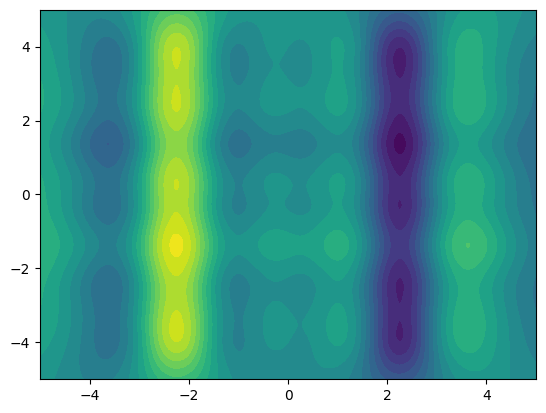

1
[2.045 1.64 ]
-1.3143894435997447


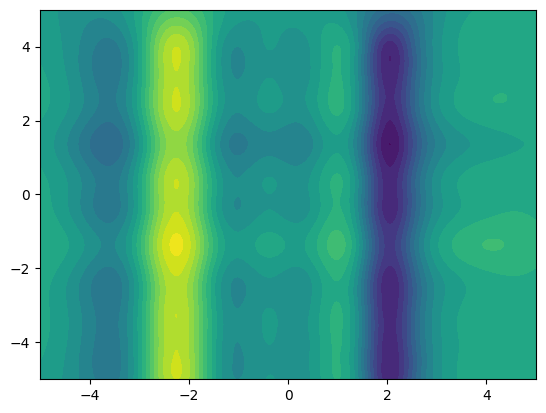

2
[2.485 1.75 ]
-0.3491063346305161


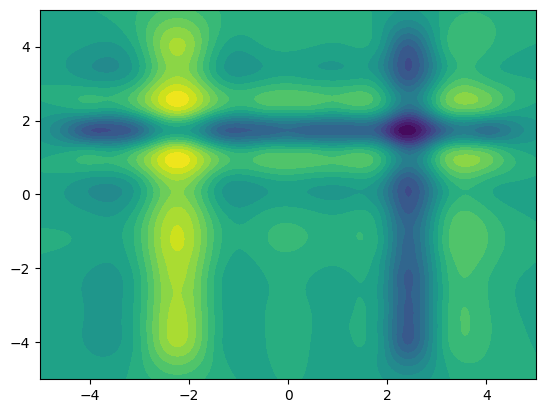

3
[1.93 1.66]
-0.9144527185504834


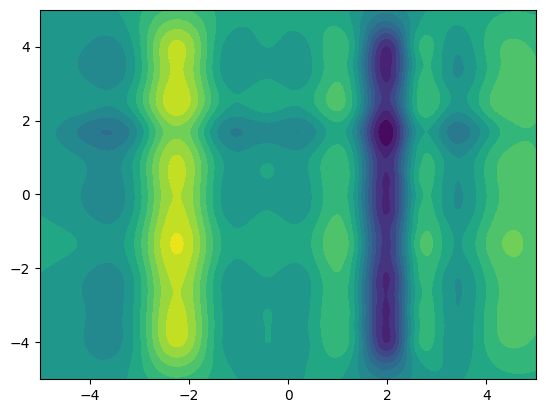

4
[2.495 1.75 ]
-0.3321531195402768


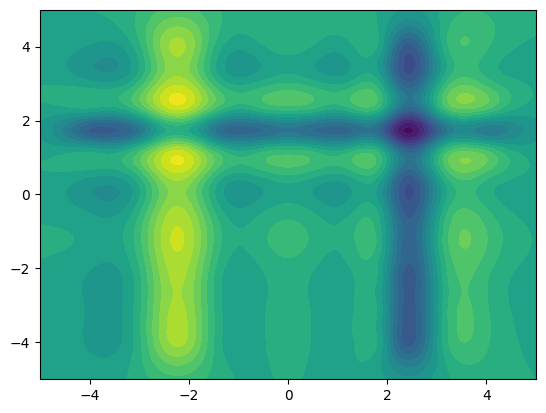

5
[1.93 1.66]
-0.9144527185504834


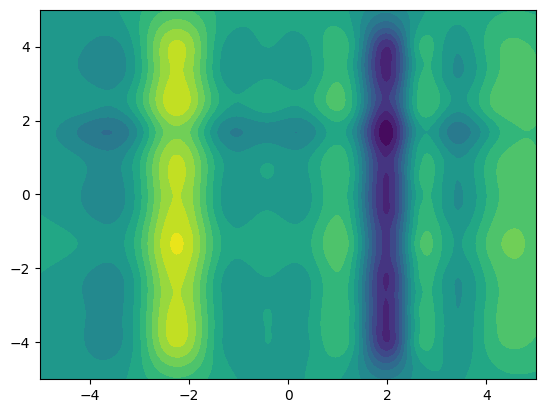

6
[2.495 1.75 ]
-0.3321531195402768


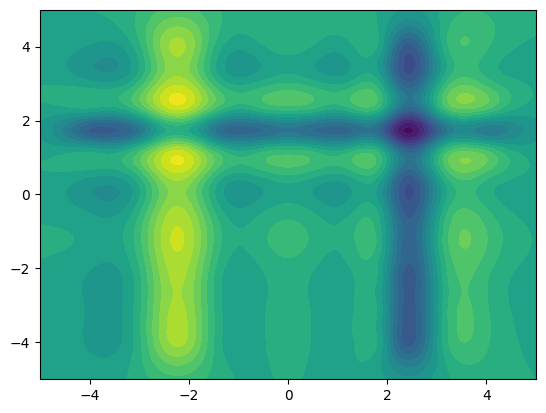

7
[1.93 1.66]
-0.9144527185504834


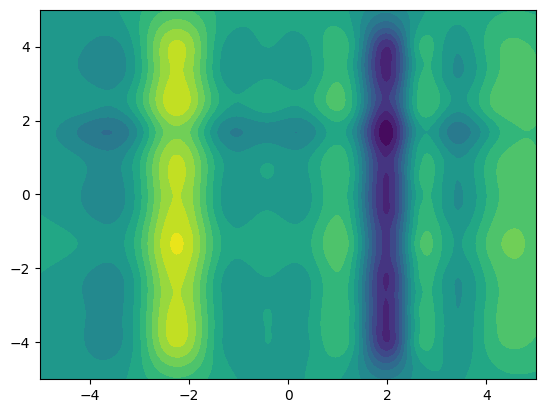

8
[2.495 1.75 ]
-0.3321531195402768


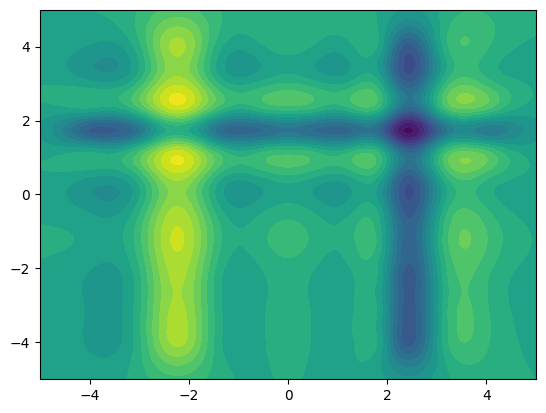

9
[1.93 1.66]
-0.9144527185504834


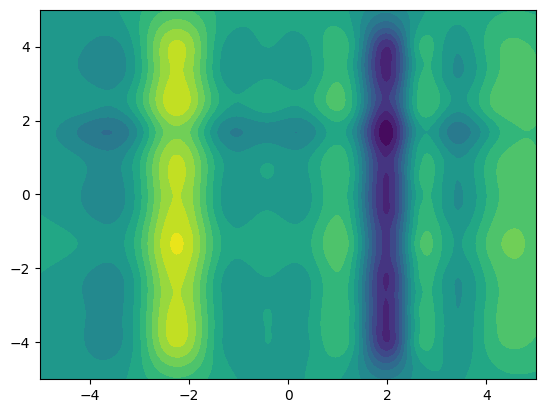

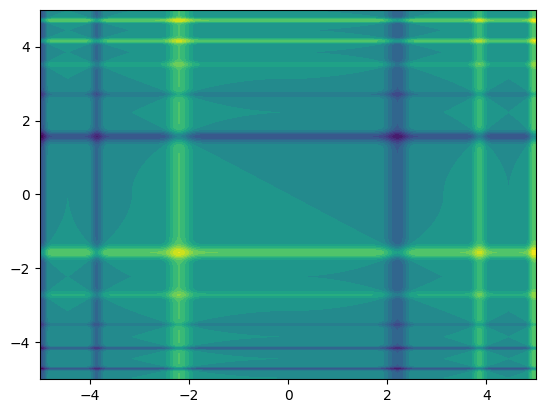

In [11]:

           
BayOpt(xystart ,f, 10)